In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import  pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [2]:
from IPython.core.pylabtools import figsize

In [3]:

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [4]:
tf.random.set_seed(1234)


In [5]:
dataset = pd.read_csv('C:/Users/rdnds/Desktop/australia/weatherAUS.csv')
print ("Total number of rows in dataset: {}\n".format(len(dataset)))
print(dataset.head())
dataset.fillna(dataset.mean(), inplace=True)
dataset[:] = np.nan_to_num(dataset)

Total number of rows in dataset: 145460

   MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0     13.4     22.9       0.6           44.0          20.0          24.0   
1      7.4     25.1       0.0           44.0           4.0          22.0   
2     12.9     25.7       0.0           46.0          19.0          26.0   
3      9.2     28.0       0.0           24.0          11.0           9.0   
4     17.5     32.3       1.0           41.0           7.0          20.0   

   Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  \
0         71.0         22.0       1007.7       1007.1     16.9     21.8   
1         44.0         25.0       1010.6       1007.8     17.2     24.3   
2         38.0         30.0       1007.6       1008.7     21.0     23.2   
3         45.0         16.0       1017.6       1012.8     18.1     26.5   
4         82.0         33.0       1010.8       1006.0     17.8     29.7   

   RainToday  RainTomorrow  
0        0.0          

In [6]:
len(dataset)

145460

In [7]:
df=dataset.iloc[:2000]

In [8]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]

In [9]:
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

Dimension of train data:  (1600, 14)
Dimension of test data:  (400, 14)


In [10]:
X_train = train_dataset.drop('RainToday', axis = 1)
y_train = train_dataset.loc[:,['RainToday']]

X_test = test_dataset.drop('RainToday', axis = 1)
y_test = test_dataset.loc[:,['RainToday']]

In [11]:
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [12]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 30
X_test, y_test = create_dataset(test_x_norm, test_y_norm,TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm,TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (370, 30, 13)
y_train.shape:  (1570, 1)
X_test.shape:  (370, 30, 13)
y_test.shape:  (1570, 1)


In [13]:
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
model_bilstm = create_model_bilstm(64)

In [14]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,validation_split = 0.2, batch_size = 32,shuffle = False, callbacks = [early_stop])
    return history
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
40/40 [==============================] - 3s 87ms/step - loss: 0.1465 - val_loss: 0.1034
Epoch 2/100
40/40 [==============================] - 2s 40ms/step - loss: 0.0855 - val_loss: 0.0603
Epoch 3/100
40/40 [==============================] - 2s 39ms/step - loss: 0.0408 - val_loss: 0.0260
Epoch 4/100
40/40 [==============================] - 1s 36ms/step - loss: 0.0132 - val_loss: 0.0065
Epoch 5/100
40/40 [==============================] - 1s 36ms/step - loss: 0.0082 - val_loss: 0.0021
Epoch 6/100
40/40 [==============================] - 2s 38ms/step - loss: 0.0021 - val_loss: 9.6600e-04
Epoch 7/100
40/40 [==============================] - 1s 36ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 8/100
40/40 [==============================] - 1s 36ms/step - loss: 0.0011 - val_loss: 5.9678e-04
Epoch 9/100
40/40 [==============================] - 2s 38ms/step - loss: 4.4623e-04 - val_loss: 3.4009e-04
Epoch 10/100
40/40 [==============================] - 1s 37ms/step - loss: 4.9404e-0

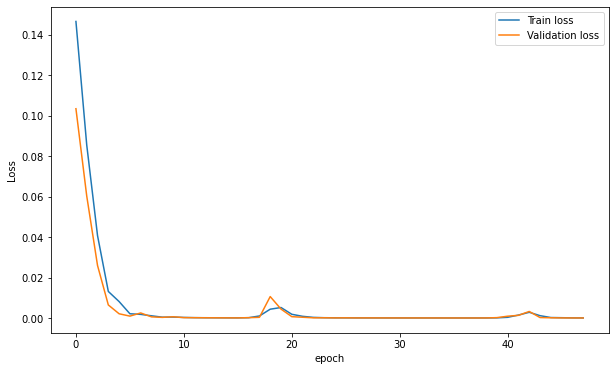

In [15]:
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_bilstm)

In [16]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [25]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)

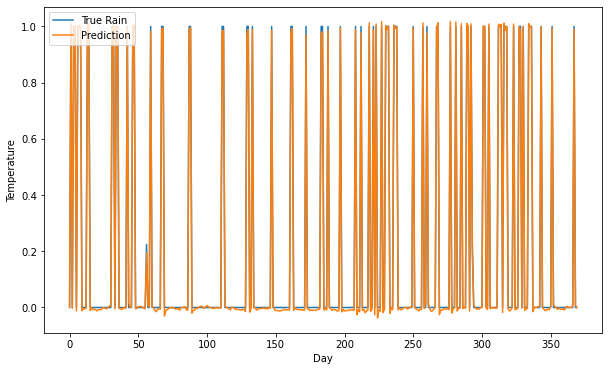

In [26]:
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Rain')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Day')
    plt.ylabel('Temperature')
plot_future(prediction_bilstm, y_test)

In [27]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))

In [28]:
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')


Bidirectional LSTM:
Mean Absolute Error: 0.0070
Root Mean Square Error: 0.0094
